### DLP Lab3
Goal of this lab is to predict diabetic retinopathy

#### Requirment
1. Implement **ResNet18**, **ResNet50**
2. Compare accuracy between the pretrained model and without pretraining of each epoch
3. Implement own Dataloader
4. Calculate the confusion matrix

#### Hyper parameters
* Batch size= 4
* Learning rate = 1e-3
* Epochs = 10(resnet18), 5(resnet50)
* Optimizer: SGD
* momentum = 0.9 weight_decay = 5e-4
* Loss function: torch.nn.CrossEntropyLoss()

Date: 2020/04/21

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
import json

In [2]:
import pandas as pd
from torch.utils import data
import numpy as np
from PIL import Image

def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))
        
        self.transformations = transforms.Compose([
                                  transforms.RandomRotation(30),
                                  transforms.ToTensor()
                              ])
        
        
    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        
        path = self.root + self.img_name[index] + '.jpeg'
        img = self.transformations(Image.open(path))
        
        label = self.label[index]

        return img, label

In [3]:
trainset = RetinopathyLoader("data/", "train")
testset = RetinopathyLoader("data/", "test")

> Found 28099 images...
> Found 7025 images...


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


#### Show result

In [5]:
def show_result(accuracy, model):            
    label = ["Train(with pretraining)", "Train(w/o pretraining)", "Test(with pretraining)", "Test(w/o pretraining)"]
    
    plt.figure(figsize=(10, 6))
    
    plt.ylabel("Accuracy(%)")
    plt.xlabel("Epochs")
    plt.title("Result comparison("+model+")", fontsize=18)
    plt.yticks(np.arange(0.7, 0.9, step=0.02))
    
    for idx, acc in enumerate(accuracy):
        plt.plot(acc, label=label[idx], marker='o')

    plt.legend()
    plt.show()

In [6]:
def plot_confusion_matrix(y_true, y_pred, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    else:
        cm = cm.astype("float")/cm.sum()
    plt.figure(figsize=(20, 6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()

    plt.xticks(np.arange(5), rotation=45)
    plt.yticks(np.arange(5))
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=("%.2f"%cm[i][j]), va='center', ha='center')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### Predict

In [7]:
# predict and calculate accuracy
def get_predict(model, loader, plot=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    predictions = None
    labels = None
    total = 0
    correct = 0
    
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            label = label.to(device)
            
            # forward pass
            output = model(data)
            output = nn.Softmax(dim=1)(output)
            
            # get output label
            _, pred = torch.max(output, 1)

            total += label.shape[0]
            correct += torch.sum(pred == label).item()
            
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
            
            # if plot=True, keep labels for confusion matrix
            if plot:
                if labels is None:
                    labels = label
                else:
                    labels = torch.cat((labels, label))
                    
    # plot condusion matrix
    if plot:
        plot_confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), normalize=True)
                
    acc = correct / total
            
    return predictions, acc

#### Training

In [8]:
def train(model, trainset, testset, batch_size=4, epochs=10, lr=1e-3, model_name=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.train()

    # creare dataloaders
    trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
    testloader = DataLoader(testset, batch_size=batch_size)

    # set optimizer, loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)#5e-4

    # record acc
    train_acc_list = []
    test_acc_list = []
    max_acc = 0

    for epoch in range(epochs):
        since = time.time()

        for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)

            # set parameter gradient into zero
            optimizer.zero_grad()

            # forward pass
            output = model(data)

            # backward
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

        # print accuracy each epoch
        _, train_acc = get_predict(model, trainloader)
        train_acc_list.append(train_acc)           
        _, test_acc = get_predict(model, testloader)
        test_acc_list.append(test_acc)
        print ("Epoch: %2s, train accuracy: %8s, test accuracy: %8s - time: %4s\n"%
               (epoch, train_acc, test_acc, (time.time() - since)/60.0))
        if test_acc > max_acc and test_acc > 0.801:
            torch.save(model, "./models/"+model_name)
            max_acc = test_acc

    print ("The highest accuracy of %s model is %s"%(model_name, max_acc))

    return train_acc_list, test_acc_list

### ResNet18 with pretraining

In [9]:
model_ft_18 = models.resnet18(pretrained=True)
model_ft_18.fc = nn.Linear(512, 5)
model_ft_18.to(device)
model_ft_18.float()
print(model_ft_18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
train_ft_18, test_ft_18 = train(model_ft_18, trainset, testset, batch_size=8, epochs=12 , lr=1e-3, model_name="resnet18_ft")
print (train_ft_18)
print (test_ft_18)

Epoch:  0, train accuracy: 0.769600341649169, test accuracy: 0.7648398576512455 - time: 9.361600557963053

Epoch:  1, train accuracy: 0.7940496103064166, test accuracy: 0.7843416370106762 - time: 9.402838774522145

Epoch:  2, train accuracy: 0.8065411580483292, test accuracy: 0.7916014234875445 - time: 9.075850653648377

Epoch:  3, train accuracy: 0.8119150147692089, test accuracy: 0.7974377224199288 - time: 9.198906854788463

Epoch:  4, train accuracy: 0.8224491974803374, test accuracy: 0.8017081850533808 - time: 9.20286507209142

Epoch:  5, train accuracy: 0.8230542012171251, test accuracy: 0.8037010676156584 - time: 9.131800421079

Epoch:  6, train accuracy: 0.8289974732196875, test accuracy: 0.8052669039145908 - time: 9.163971531391145

Epoch:  7, train accuracy: 0.8322004341791522, test accuracy: 0.8032740213523132 - time: 9.200462154547374

Epoch:  8, train accuracy: 0.834300153030357, test accuracy: 0.8052669039145908 - time: 9.133685882886251

Epoch:  9, train accuracy: 0.84049

In [100]:
dic = {"train_ft_18": train_ft_18, "test_ft_18": test_ft_18}
with open('acc_list', 'a+') as outfile:
    json.dump(dic, outfile)
    outfile.write("\n")

### ResNet50 with pretraining

In [52]:
model_ft_50 = models.resnet50(pretrained=True)
model_ft_50.fc = nn.Linear(2048, 5)
model_ft_50.to(device)
model_ft_50.float()
print(model_ft_50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
train_ft_50, test_ft_50 = train(model_ft_50, trainset, testset, batch_size=4, epochs=5 , lr=1e-3, model_name="resnet50_ft")
print (train_ft_50)
print (test_ft_50)

Epoch:  0, train accuracy: 0.7795295206235098, test accuracy: 0.773950177935943 - time: 29.131244913736978

Epoch:  1, train accuracy: 0.8025196626214456, test accuracy: 0.7908896797153024 - time: 28.287156240145364

Epoch:  2, train accuracy: 0.8131961991529948, test accuracy: 0.7910320284697508 - time: 28.614192450046538

Epoch:  3, train accuracy: 0.8200291825331862, test accuracy: 0.7931672597864768 - time: 28.429967518647512

Epoch:  4, train accuracy: 0.8207409516352895, test accuracy: 0.7826334519572954 - time: 28.560360876719155

The highest accuracy of resnet50_ft model is 0.7931672597864768
[0.7795295206235098, 0.8025196626214456, 0.8131961991529948, 0.8200291825331862, 0.8207409516352895]
[0.773950177935943, 0.7908896797153024, 0.7910320284697508, 0.7931672597864768, 0.7826334519572954]


In [86]:
dic = {"train_ft_50": train_ft_50, "test_ft_50": test_ft_50}
with open('acc_list', 'a+') as outfile:
    json.dump(dic, outfile)
    outfile.write("\n")

1

### ResNet18 w/o pretraining

In [10]:
model_18 = models.resnet18(pretrained=False)
model_18.fc = nn.Linear(512, 5)
model_18.to(device)
model_18.float()
print(model_18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
train_18, test_18 = train(model_18, trainset, testset, batch_size=8, epochs=12 , lr=1e-3, model_name="resnet18")
print (train_18)
print (test_18)

Epoch:  0, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 9.151128828525543

Epoch:  1, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 9.133767422040304

Epoch:  2, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 9.0785648783048

Epoch:  3, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 8.932403878370922

Epoch:  4, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 8.923304498195648

Epoch:  5, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 8.918362589677175

Epoch:  6, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 8.907439247767131

Epoch:  7, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 8.90775524377823

Epoch:  8, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 8.897844938437144

Epoch:  9, train accuracy: 0.73507954019716, test

In [87]:
print (train_18)
print (test_18)
dic = {"train_18": train_18, "test_18": test_18}
with open('acc_list', 'a+') as outfile:
    json.dump(dic, outfile)
    outfile.write("\n")

[0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716]
[0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979]


1

In [89]:
torch.cuda.empty_cache()

### ResNet50 w/o pretraining

In [7]:
model_50 = models.resnet50(pretrained=False)
model_50.fc = nn.Linear(2048, 5)
model_50.to(device)
model_50.float()
print(model_50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
train_50, test_50 = train(model_50, trainset, testset, batch_size=4, epochs=5 , lr=1e-3, model_name="resnet50")
print (train_50)
print (test_50)

Epoch:  0, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 29.46248876651128

Epoch:  1, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 30.193139429887136

Epoch:  2, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 29.190789592266082

Epoch:  3, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 27.94587350289027

Epoch:  4, train accuracy: 0.73507954019716, test accuracy: 0.7335231316725979 - time: 29.161498125394186

The highest accuracy of resnet50 model is 0.7335231316725979
[0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716]


NameError: name 'teat_50' is not defined

In [16]:
print (train_50)
print (test_50)
dic = {"train_50": train_50, "test_50": test_50}
with open('acc_list', 'a+') as outfile:
    json.dump(dic, outfile)
    outfile.write("\n")

[0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716, 0.73507954019716]
[0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979, 0.7335231316725979]


1

In [17]:
outfile.close()

#### Load result and plot

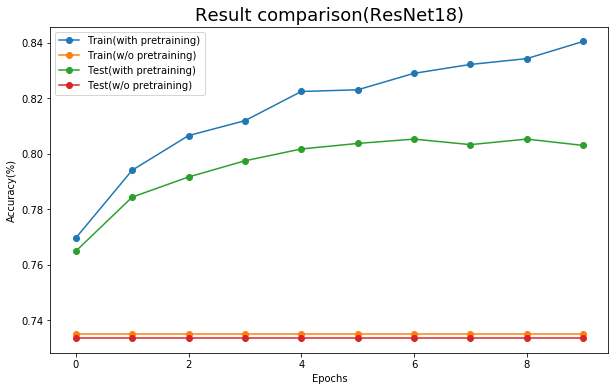

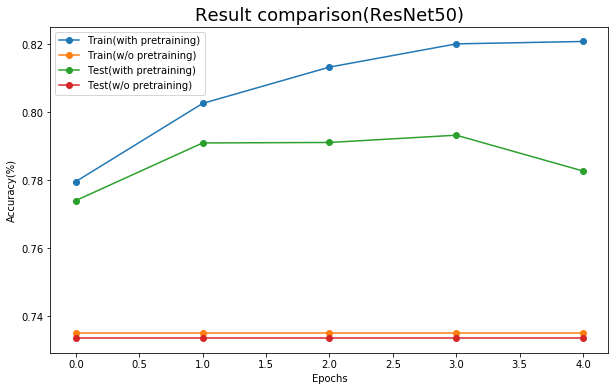

In [19]:
acc_list = []
with open('acc_list', 'r') as outfile:
    for line in outfile:
        dic = json.loads(line)
        acc_list.extend([acc for acc in dic.values()])
        
resnet18_acc = [acc_list[0][:10], acc_list[4], acc_list[1][:10], acc_list[5]]
show_result(resnet18_acc, "ResNet18")
resnet50_acc = [acc_list[2], acc_list[6], acc_list[3], acc_list[7]]
show_result(resnet50_acc, "ResNet50")

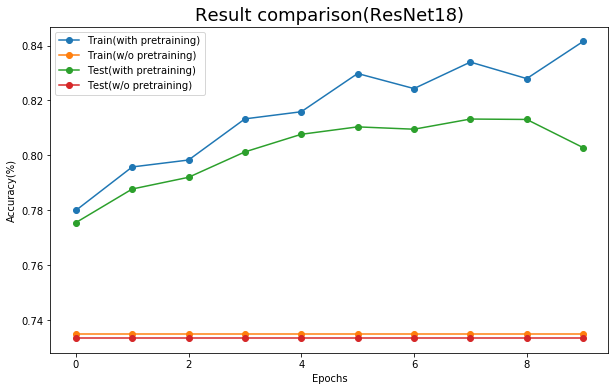

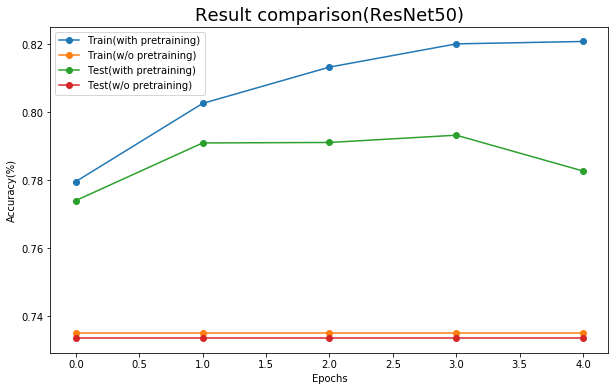

In [24]:
acc_list = []
with open('acc_list', 'r') as outfile:
    for line in outfile:
        dic = json.loads(line)
        acc_list.extend([acc for acc in dic.values()])
        
resnet18_acc = [acc_list[0][:10], acc_list[4], acc_list[1][:10], acc_list[5]]
show_result(resnet18_acc, "ResNet18")
resnet50_acc = [acc_list[2], acc_list[6], acc_list[3], acc_list[7]]
show_result(resnet50_acc, "ResNet50")

#### Predict and confusion matrix

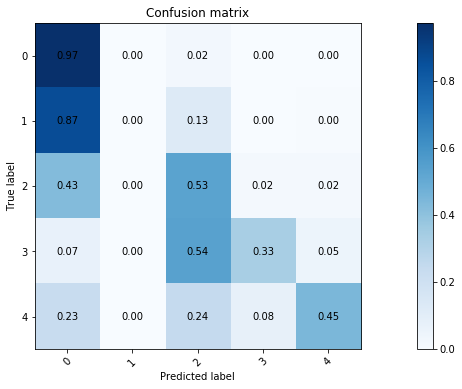

Accuracy of resnet18_ft: 0.8128113879003559


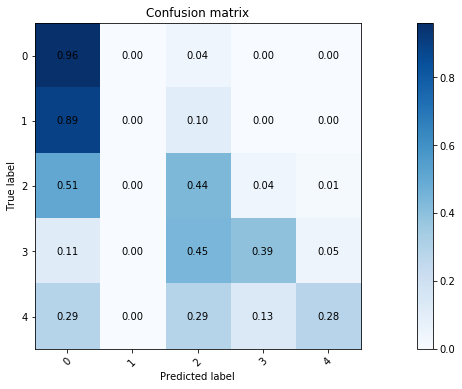

Accuracy of resnet50_ft: 0.7869039145907474


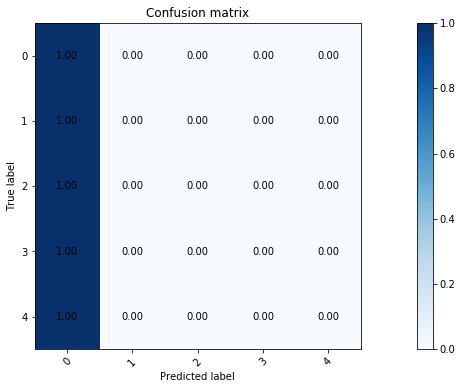

Accuracy of resnet18: 0.7335231316725979


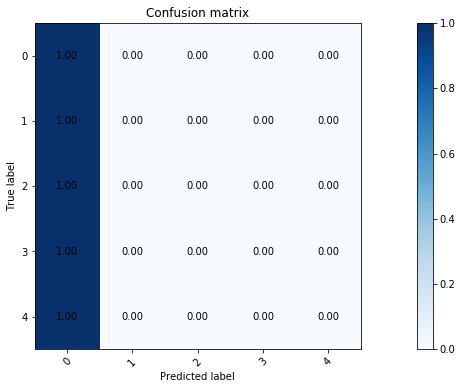

Accuracy of resnet50: 0.7335231316725979


In [25]:
model_names = ["resnet18_ft", "resnet50_ft", "resnet18", "resnet50"]
path = "./models/"
testloader = DataLoader(testset, batch_size=8)

for model_name in model_names:
    model = torch.load(path+model_name)
    _, acc = get_predict(model, testloader, True)
    print ("Accuracy of %s: %s"%(model_name, acc))

In [26]:
model_names = ["resnet18_ft", "resnet50_ft", "resnet18", "resnet50"]
path = "./models/"
testloader = DataLoader(testset, batch_size=8)

for model_name in model_names:
    model = torch.load(path+model_name)
    _, acc = get_predict(model, testloader, False)
    print ("Accuracy of %s: %s"%(model_name, acc))

Accuracy of resnet18_ft: 0.8145195729537367
Accuracy of resnet50_ft: 0.7829181494661922
Accuracy of resnet18: 0.7335231316725979
Accuracy of resnet50: 0.7335231316725979
